In [4]:
import pandas as pd
import numpy as np
import os

import json

class Config():

    def __init__(self,fconfig):
        config = json.load(fconfig)
        self.name_main_sample = config['name_sample']
        self.name_sample = config['name_sample'] + config['additional_name']
        self.general_path = config['general_path']
        self.data_path = config['data_path']
        self.prediction_path = config['prediction_path']
        self.test_path = config['test_path'] ############
        self.flags = config['flags']
        self.hyperparam = config['hyperparam']
        self.features = config['features']
        self.name_class = config['name_class']
        self.name_class_column = config["name_class_column"]
        self.base = config["base"]
        self.picture = config['picture']
        self.statistic = config['statistic']
        #
        self.path_ml_data = f'{self.general_path}/ml/data'
        self.path_ml = f'{self.general_path}/ml'
        self.path_sample = f'{self.general_path}/sample'
        self.path_pic = f'{self.general_path}/ml/picture'
        self.path_stat = f'{self.general_path}/statistic'
        #
        self.path_model = f"{self.path_ml}/model/mod_{self.name_sample}"
        self.path_weight = f"{self.path_ml}/model/weight_{self.name_sample}"
        self.path_eval = f"{self.path_ml}/eval/{self.name_sample}"
        self.path_predict = f"{self.path_ml}/prediction/{self.name_sample}"
        #
        columns = []
        columns_prob = []
        for col in self.name_class:
            columns.append(f"{col}_cls")
            columns_prob.append(f"{col}_cls_prob")
        self.name_class_cls = columns
        self.name_class_prob = columns_prob

In [5]:
fconfig = open('config_agn_sdss_var.json')
config_var = Config(fconfig)
fconfig.close()
del fconfig

fconfig = open('config_agn_sdss_color.json')
config_color = Config(fconfig)
fconfig.close()
del fconfig

fconfig = open('config_agn_sdss_var&color.json')
config_var_color = Config(fconfig)
fconfig.close()
del fconfig

In [8]:
fconfig = open('config_agn_sdss_c.json')
config_c = Config(fconfig)
fconfig.close()
del fconfig

In [6]:
from data_process import data_preparation

def select_data(config):
    #data = pd.DataFrame()
    #data preparation
    if(not config.flags['data_preprocessing']['work']):
        if(os.path.isfile(f'{config.path_ml_data}/{config.name_main_sample}_all.csv')):
            data = pd.read_csv(f'{config.path_ml_data}/{config.name_main_sample}_all.csv', header = 0, sep = ',')
        else:
            data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)
    else:
        data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)
    
    return data

In [5]:
from network import NN
from data_process import data_preparation, get_features

#network training
def network(data,config):
    #features from config
    #name from config
    print('Sample name: ', config.name_sample)
    print('Features: ', config.features["data"])
    
    #hyperparams from config
    batch_size = config.hyperparam['batch_size']
    num_ep = config.hyperparam['num_ep']
    optimizer = config.hyperparam['optimizer']
    loss = config.hyperparam['loss']
    validation_split = config.hyperparam['validation_split']
    
    #balanced class
    class_weights = None
    if(config.hyperparam["model_variable"]["balanced"]):
        from sklearn.utils import class_weight
        y = np.zeros(data.shape[0])
        cl = np.array(data[config.name_class_cls].values)
        #print(cl)
        for i in range(data.shape[0]):
            y[i] = np.argmax(cl[i,:])
        class_weights = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(y),y = y)))
        print("class weights",class_weights)
        del y, cl

    print(data)

    print("Features mode list:\t",config.features["train"])
    features = get_features(config.features["train"],config)
    print("Features train values:\t",features)
    
    #sample_weight
    sample_weight = None
    if(config.hyperparam["model_variable"]["sample_weight"] in config.flags['data_preprocessing']['main_sample']['weight']['method']):
        #sample_weight = data[config.hyperparam["model_variable"]["sample_weight"]].values
        sample_weight = data[config.hyperparam["model_variable"]["sample_weight"]].values.T[0]
        print(sample_weight)

    try:
        data[features]
    except:
        raise Exception("data don't have initiated features, check config.features['train'] value and WARNINGs above")

    if(config.hyperparam["model_variable"]["work"]):
        NN(data[features],data[config.name_class_cls],data['z'],sample_weight,validation_split,batch_size,num_ep,optimizer,loss,class_weights,
        output_path_predict = config.path_predict,
        output_path_mod = config.path_model,
        output_path_weight = config.path_weight,
        path_save_eval = config.path_eval,
        config=config)

2024-05-03 05:43:19.349281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
data = select_data(config_c)

data

RA        DEC         z     z_err   angDist  angDist.1   
0      251.827110  20.200372  0.115354  0.000028  0.030303   0.138046  \
1      141.549250  41.631594  1.138170  0.000443  0.121704   0.073535   
2       95.530869  -0.809528  0.000233  0.000005  0.049109   0.227537   
3      331.128910  21.820291 -0.000217  0.000011  0.041747   0.157691   
4      189.761280   7.107970  0.160179  0.000015  0.088381   0.254740   
...           ...        ...       ...       ...       ...        ...   
96331  125.883290  45.292969  0.171708  0.000007  0.092753   0.274260   
96332  251.608690  34.994652 -0.000244  0.000007  0.080912   0.083234   
96333  322.009740   0.019939  0.051971  0.000006  0.233083   0.217843   
96334  241.576570  54.930858 -0.000155  0.000007  0.230241   0.245534   
96335  167.389080  28.500960  0.074576  0.000012  0.167285   0.046991   

           PQSO      PGal       PSS  nW1  ...     mcd_d     mcd_g  fuzzy_err   
0      0.000000  0.039126  0.957413   12  ...  0.882374  0.275316   0.687209  \
1      0.008547  0.000171  0.989797   12  ...  1.680293  0.411247   0.651426   
2      0.000000  0.000000  0.999991   12  ...  2.379717  0.229896   0.707559   
3      0.000000  0.000000  0.999990   12  ...  1.395187  0.290248   0.639507   
4      0.000000  1.000000  0.000000   12  ...  1.081847  0.329161   0.682550   
...         ...       ...       ...  ...  ...       ...       ...        ...   
96331  0.000000  1.000000  0.000000   11  ...  1.348914  0.410013   0.674255   
96332  0.000000  0.000000  0.999977   12  ...  1.400993  0.290286   0.693111   
96333  0.000000  1.000000  0.000000   12  ...  1.918231  0.468507   0.661796   
96334  0.000000  0.000000  0.999979   13  ...  0.401803  0.218189   0.691557   
96335  0.000982  0.038839  0.960128   12  ...  1.040616  0.315354   0.619674   

       fuzzy_dist  qso_cls  agn_cls  sbg_cls  sfg_cls  gal_cls  star_cls  
0        0.818188        0        0        0        0        1         0  
1        0.741110        1        0        0        0        0         0  
2        0.576679        0        0        0        0        0         1  
3        0.909349        0        0        0        0        0         1  
4        0.767979        0        0        0        1        0         0  
...           ...      ...      ...      ...      ...      ...       ...  
96331    0.876414        0        0        0        1        0         0  
96332    0.793113        0        0        0        0        0         1  
96333    0.637165        0        0        0        1        0         0  
96334    0.944406        0        0        0        0        0         1  
96335    0.759409        0        0        0        1        0         0  

[96336 rows x 70 columns]

In [51]:
network(data,config_var)
network(data,config_color)
network(data,config_var_color)

Sample name:  sdss_diploma_sample_dereddedcut_rangecut_flux_color_mcdcut_cbalancedfalse_wbalanced_e200_v02_arelu_erecall_ldropout_var
Features:  {'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']}
class weights {0: 0.5069758293997523, 1: 11.318292227204783, 2: 8.05632397925256, 3: 2.162741294361269, 4: 0.48256051706374076, 5: 0.7810146982980918}
                 RA        DEC         z     z_err   angDist  angDist.1   
0        239.177460  27.055966  0.090353  0.000027  0.086462   0.171325  \
1        169.268150   4.427474  1.170077  0.000150  0.032336   0.068488   
2         43.250305  -3.342976  0.244153  0.000030  0.200110   0.594563   
3        172.780700  45.426833  1.229971  0.000552  0.045566   0.092679   
4        1

In [5]:
from statistic import metric_sklearn, metric_, main_metrics, kfold_metrics

2024-05-11 11:55:12.294260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [57]:
def picture_metrics(one_ml_cycle_main_mass,one_ml_cycle_all_kfold_mass,picture_label,config):
    a,b = 2,2
    from matplotlib import pyplot as plt
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    def pic(axs,i,j,l,one_ml_cycle_main,one_ml_cycle_all_kfold):

        axs[i,j].scatter(index_mass,one_ml_cycle_main.loc[index[i*b+j],:],lw=10, label=f"main{picture_label[l]}", color = colors[l])
        axs[i,j].plot(index_mass,one_ml_cycle_main.loc[index[i*b+j],:],lw=5, color = colors[l])
        #axs[i,j].plot(index_mass,one_ml_cycle_all_kfold.loc[idx[index[i*b+j],'mean'],:], lw=5)
        axs[i,j].errorbar(index_mass,one_ml_cycle_all_kfold.loc[idx[index[i*b+j],'mean'],:],
                        yerr=[one_ml_cycle_all_kfold.loc[idx[index[i*b+j],'mean'],:].values - one_ml_cycle_all_kfold.loc[idx[index[i*b+j],'min'],:].values,
                                one_ml_cycle_all_kfold.loc[idx[index[i*b+j],'max'],:].values - one_ml_cycle_all_kfold.loc[idx[index[i*b+j],'mean'],:].values], 
                        fmt='o', markersize=12, elinewidth=4, capsize=20, capthick=4, label=f"kfold{picture_label[l]}", color = colors[l+1])

    index = ['precision','recall','f1','bacc','k','mcc','roc']
    idx = pd.IndexSlice

    fig=plt.figure()
    fig, axs = plt.subplots(a,b)

    index_mass = [config.name_class[i] for i in range(len(config.name_class))]
    for i in range(a):
        for j in range(b):
            #
            for l in range(len(one_ml_cycle_main_mass)):
                try:
                    pic(axs,i,j,l,one_ml_cycle_main_mass[l],one_ml_cycle_all_kfold_mass[l])
                except:
                    print()
            #
            axs[i,j].tick_params(axis='x', labelsize=30)
            axs[i,j].tick_params(axis='y', labelsize=30)
            try:
                axs[i,j].set_xlabel(index[i*b+j],fontsize=40)
            except:
                print()
            axs[i,j].legend(prop={'size': 20},loc = 4)
            axs[i,j].set_ylim([0.0,1.1])
    
    axs[1,1].set_ylim([0.6,1.05])

    fig.set_size_inches(25,17)
    plt.show()

In [7]:
one_ml_cycle_all_kfold_var_1 = kfold_metrics(True,config_var)
one_ml_cycle_all_kfold_color_1 = kfold_metrics(True,config_color)
one_ml_cycle_all_kfold_var_color_1 = kfold_metrics(True,config_var_color)

In [6]:
one_ml_cycle_all_kfold_var_color_1 = kfold_metrics(True,config_var_color)

In [8]:
%%time
one_ml_cycle_all_kfold_var = kfold_metrics(False,config_var)
one_ml_cycle_all_kfold_color = kfold_metrics(False,config_color)
one_ml_cycle_all_kfold_var_color = kfold_metrics(False,config_var_color)

CPU times: user 19.3 s, sys: 18.5 ms, total: 19.3 s
Wall time: 19.3 s


In [9]:
%%time
one_ml_cycle_main_var_1, one_ml_cycle_main_metr_var_1 = main_metrics(True,config_var)
one_ml_cycle_main_color_1, one_ml_cycle_main_metr_color_1 = main_metrics(True,config_color)
one_ml_cycle_main_var_color_1, one_ml_cycle_main_metr_var_color_1 = main_metrics(True,config_var_color)

CPU times: user 1min 44s, sys: 275 ms, total: 1min 44s
Wall time: 1min 44s


In [74]:
one_ml_cycle_main_var_color_1, one_ml_cycle_main_metr_var_color_1 = main_metrics(False,config_var_color)

In [10]:
one_ml_cycle_main_var, one_ml_cycle_main_metr_var = main_metrics(False,config_var)
one_ml_cycle_main_color, one_ml_cycle_main_metr_color = main_metrics(False,config_color)
one_ml_cycle_main_var_color, one_ml_cycle_main_metr_var_color = main_metrics(False,config_var_color)

In [11]:
one_ml_cycle_main_mass = [one_ml_cycle_main_var,one_ml_cycle_main_color,one_ml_cycle_main_var_color,one_ml_cycle_main_var_1,one_ml_cycle_main_color_1,one_ml_cycle_main_var_color_1]
one_ml_cycle_all_kfold_mass = [one_ml_cycle_all_kfold_var,one_ml_cycle_all_kfold_color,one_ml_cycle_all_kfold_var_color,one_ml_cycle_all_kfold_var_1,one_ml_cycle_all_kfold_color_1,one_ml_cycle_all_kfold_var_color_1]
picture_label = ["var","color","var_color","var_1","color_1","var_color_1"]

<h2> <i>"_1"</i> mark <b>e200+outlire</b> usage</h2>

<Figure size 640x480 with 0 Axes>

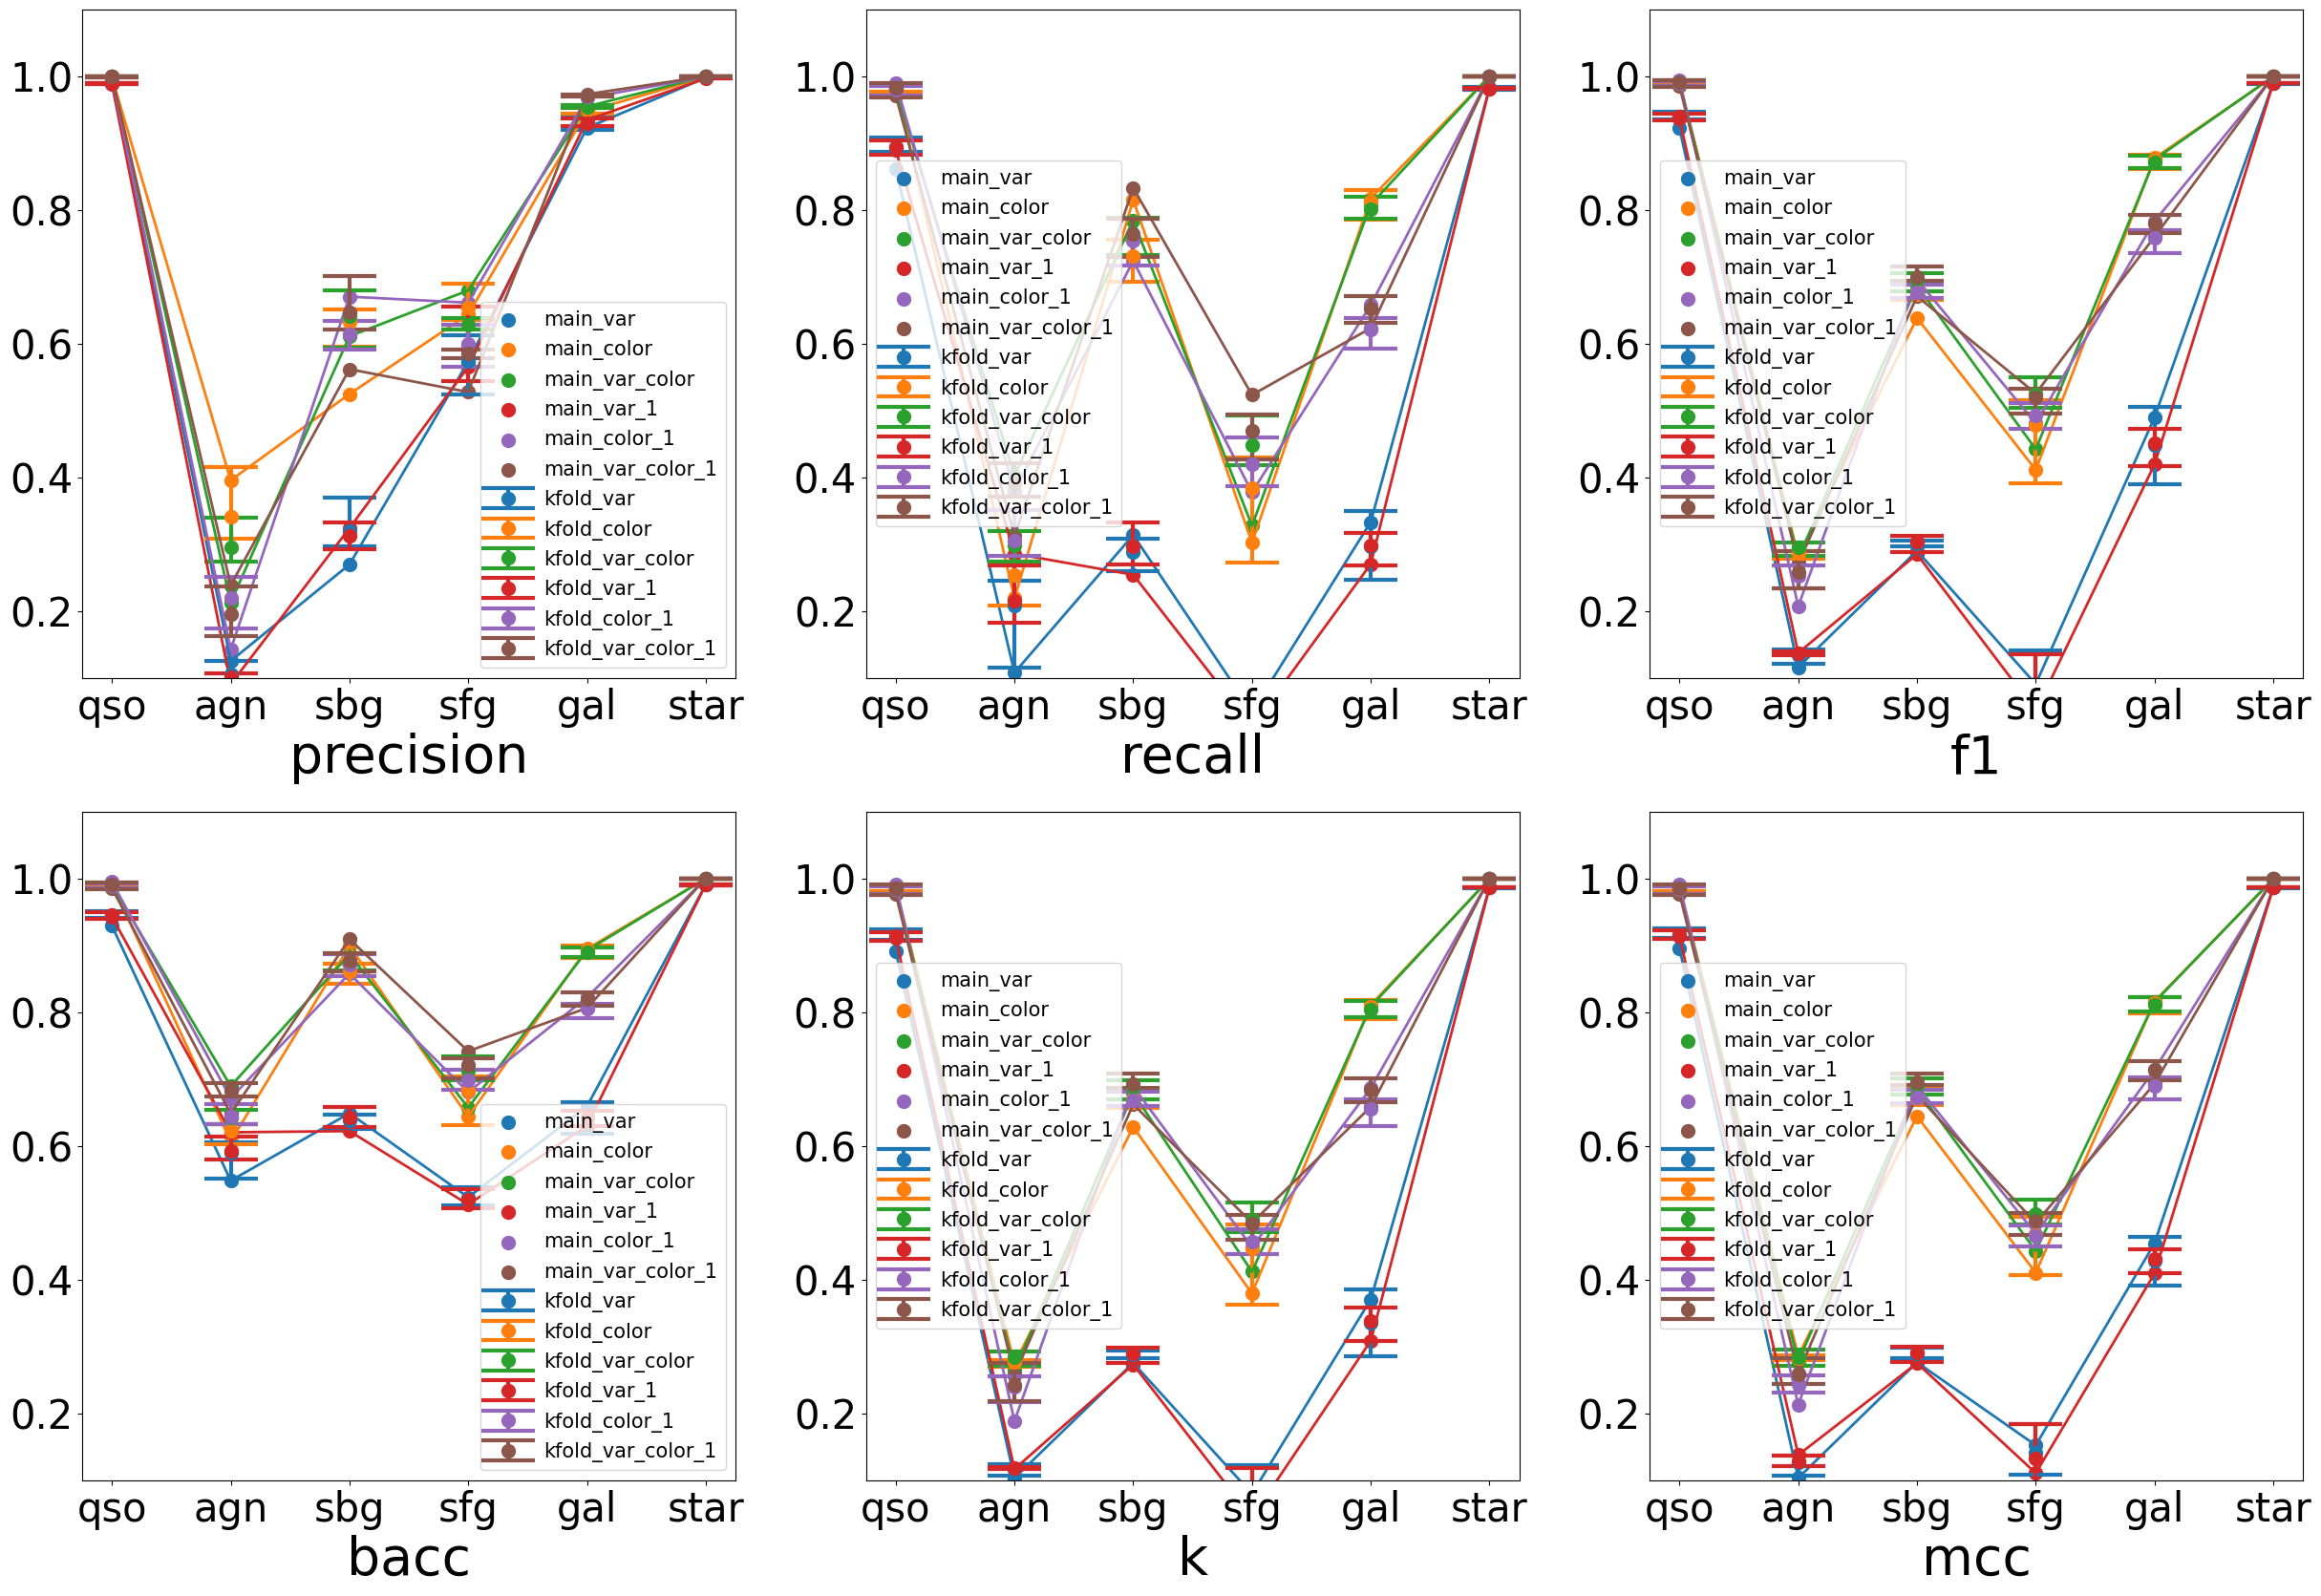

In [61]:
picture_metrics(one_ml_cycle_main_mass,one_ml_cycle_all_kfold_mass,picture_label,config_var)

<h2> <i>"_1"</i> mark <b>argmax</b> usage</h2>

<Figure size 640x480 with 0 Axes>

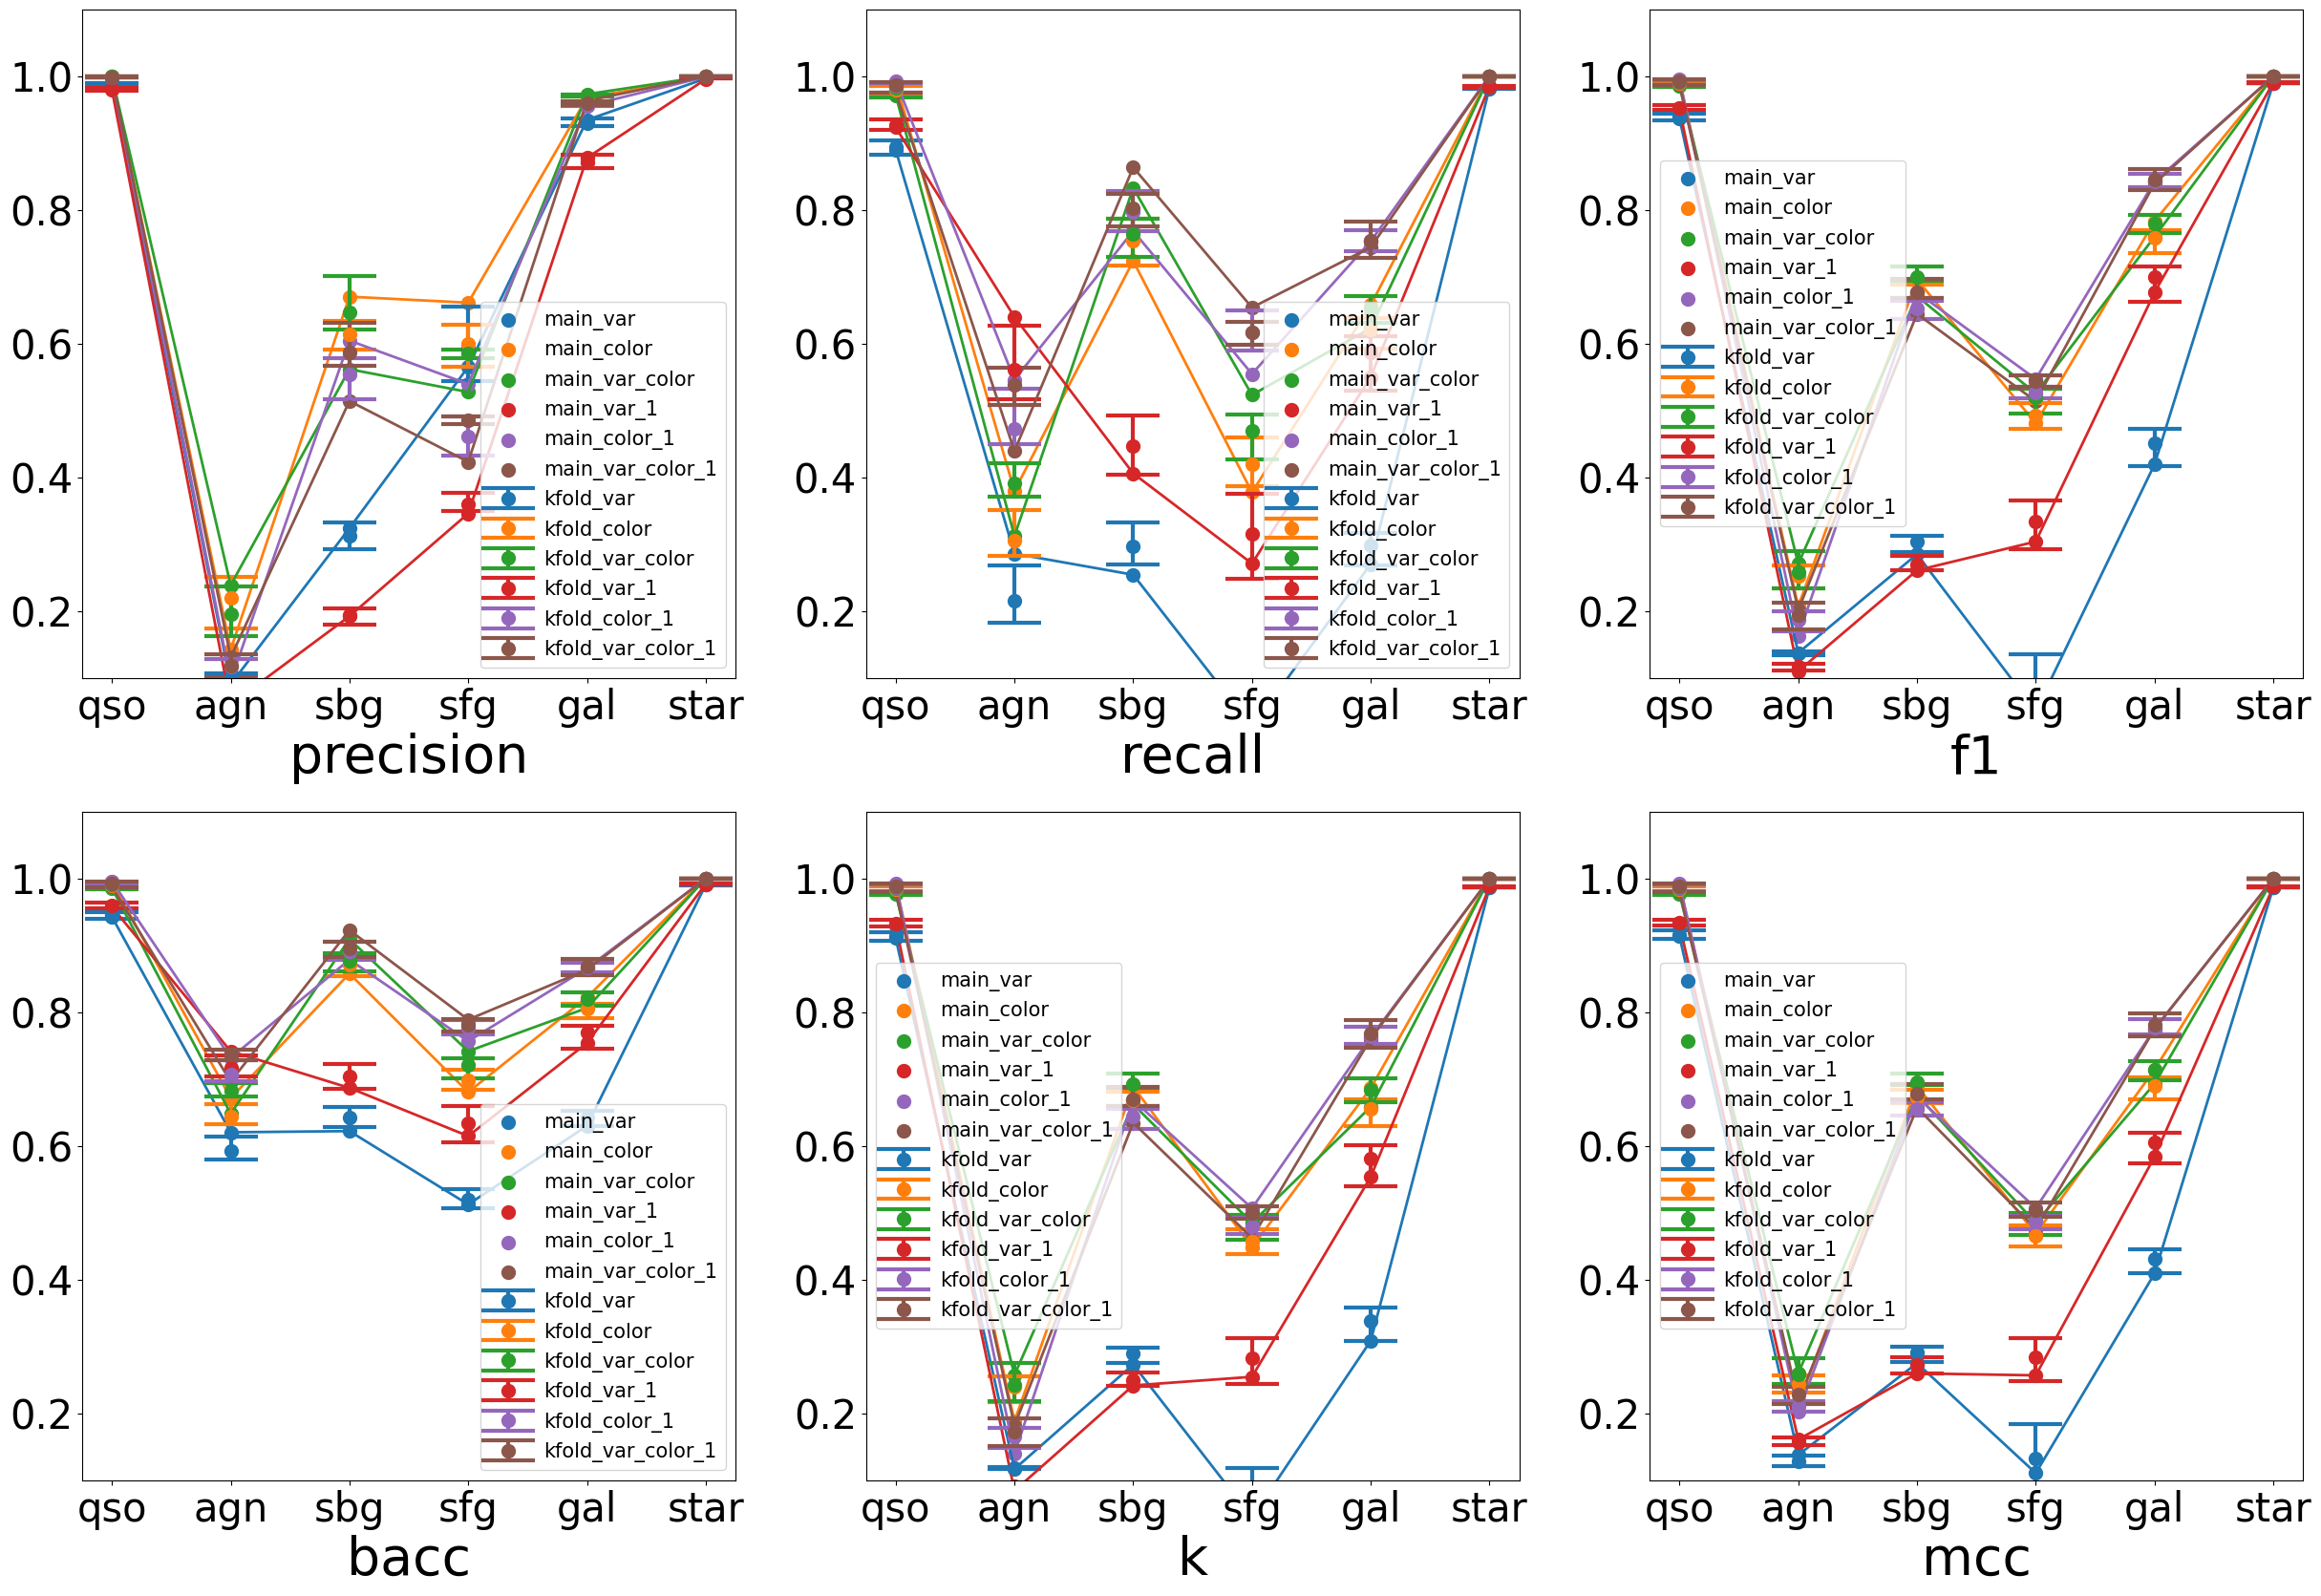

In [13]:
picture_metrics(one_ml_cycle_main_mass,one_ml_cycle_all_kfold_mass,picture_label,config_color)

<Figure size 640x480 with 0 Axes>

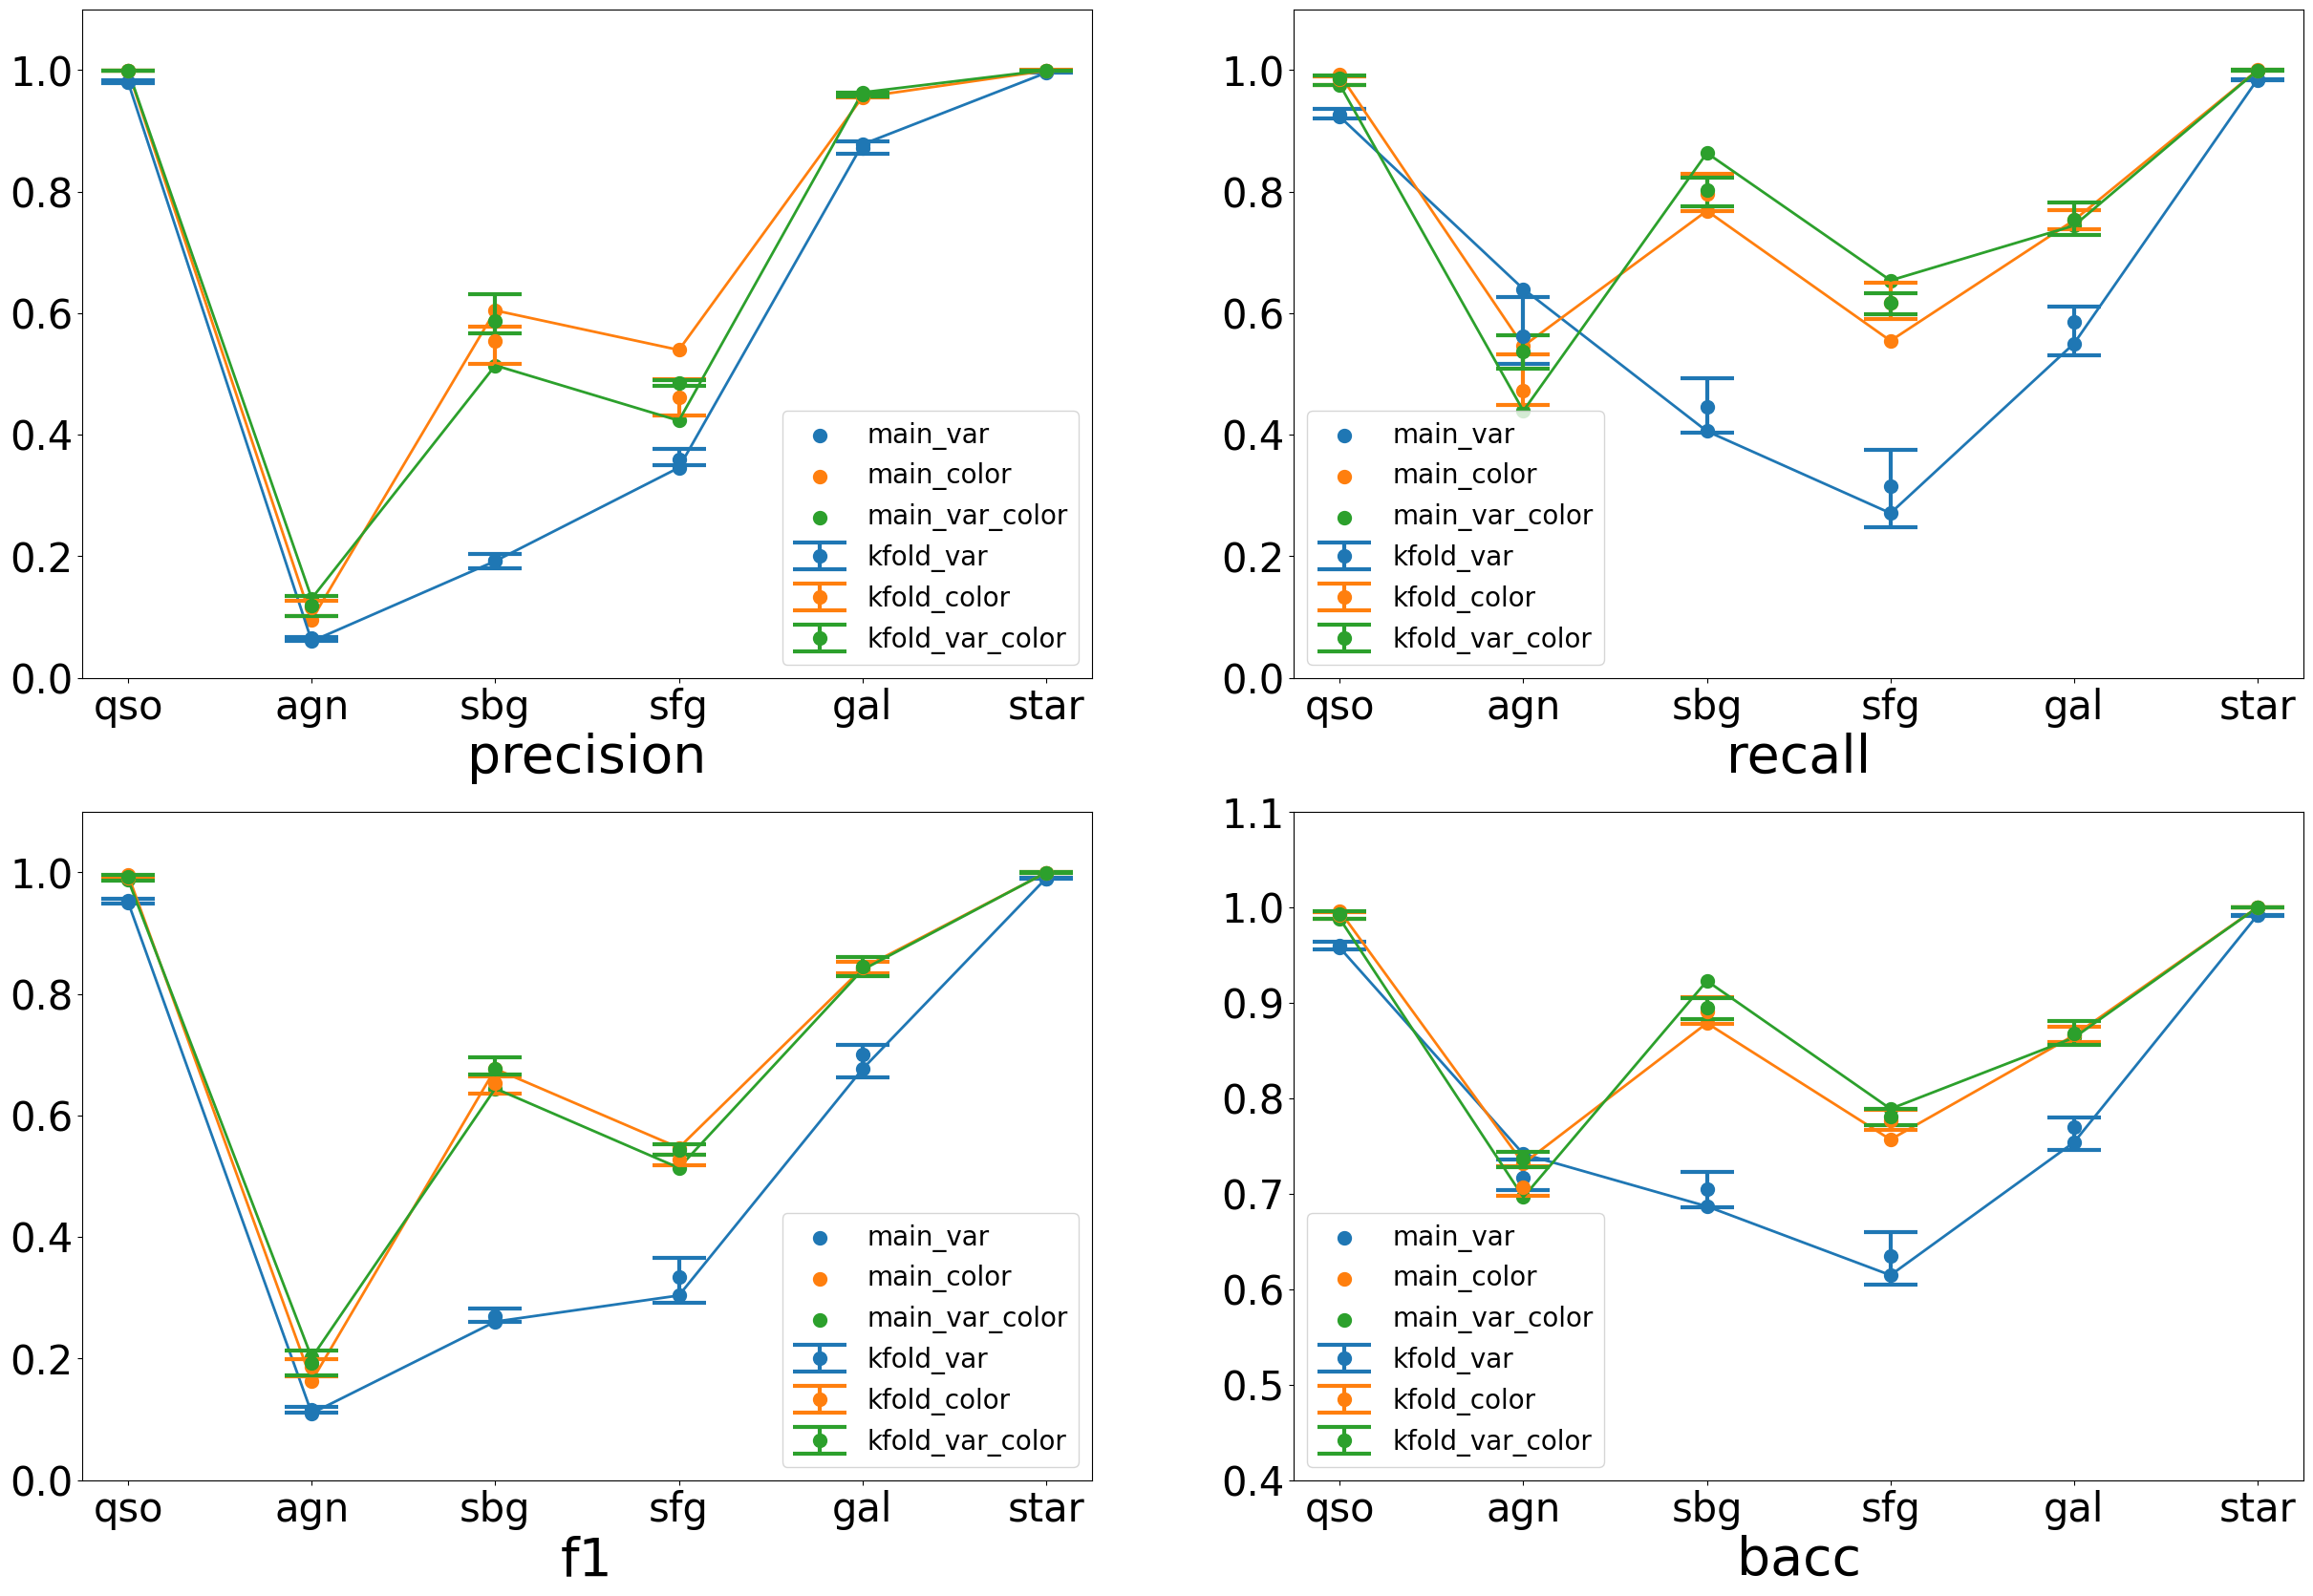

In [26]:
one_ml_cycle_main_mass = [one_ml_cycle_main_var_1,one_ml_cycle_main_color_1,one_ml_cycle_main_var_color_1]
one_ml_cycle_all_kfold_mass = [one_ml_cycle_all_kfold_var_1,one_ml_cycle_all_kfold_color_1,one_ml_cycle_all_kfold_var_color_1]
picture_label = ["var","color","var_color"]
picture_metrics(one_ml_cycle_main_mass,one_ml_cycle_all_kfold_mass,picture_label,config_color)

<Figure size 640x480 with 0 Axes>

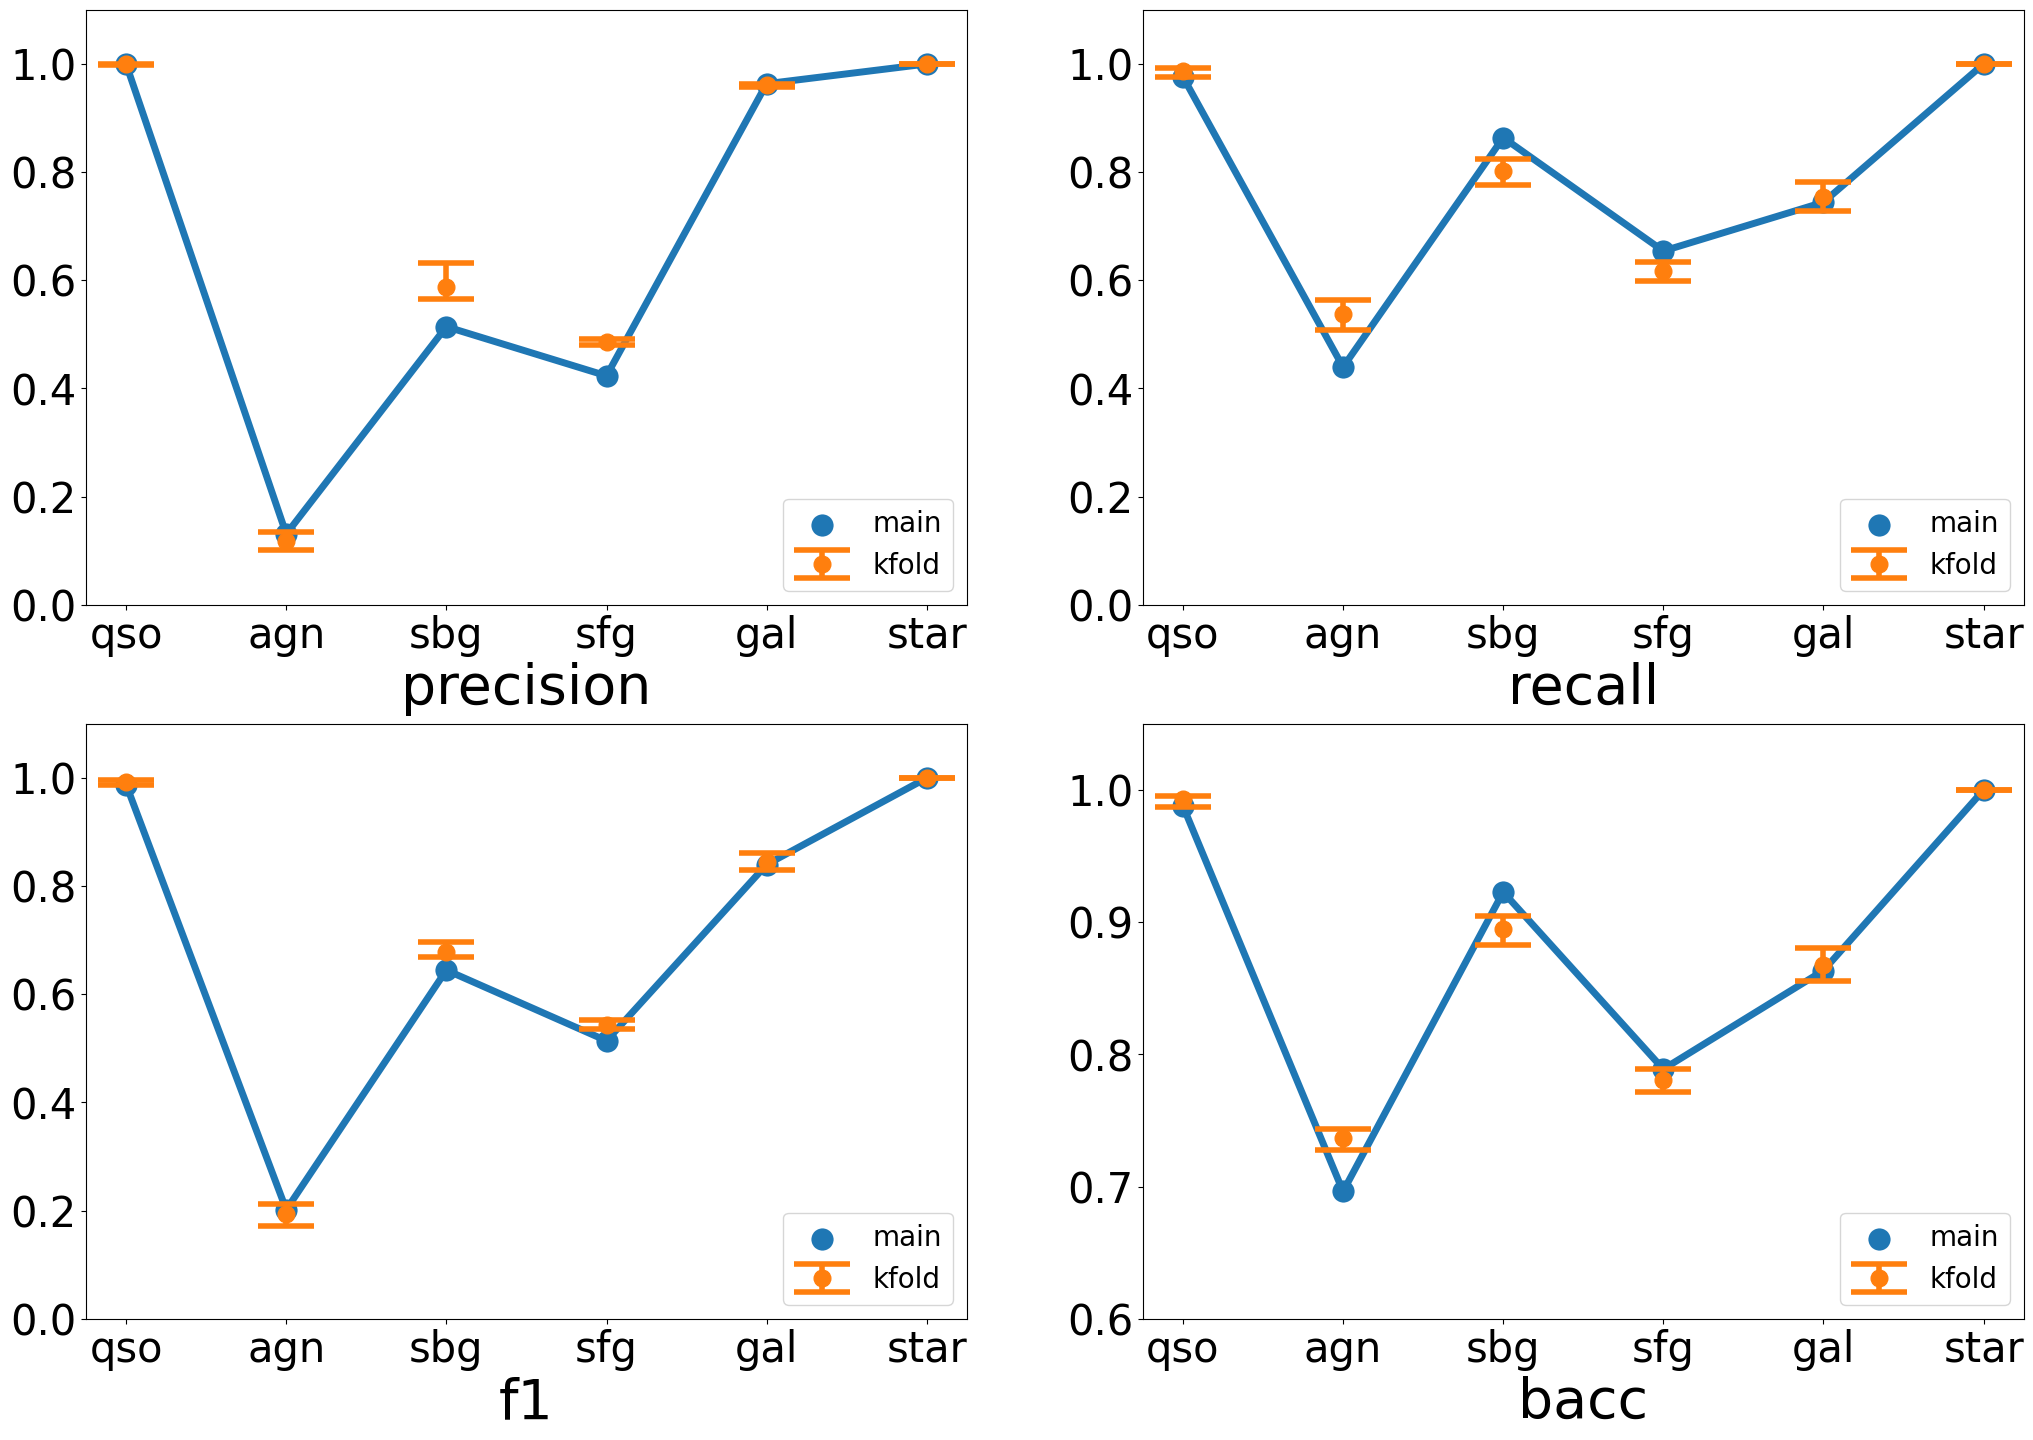

In [58]:
one_ml_cycle_main_mass = [one_ml_cycle_main_var_color_1]
one_ml_cycle_all_kfold_mass = [one_ml_cycle_all_kfold_var_color_1]
picture_label = [""]
picture_metrics(one_ml_cycle_main_mass,one_ml_cycle_all_kfold_mass,picture_label,config_color)

In [64]:
one_ml_cycle_main_var_color_1.transpose()[["precision","recall","f1","bacc"]].astype(float).round(4)*100

precision  recall     f1   bacc
qso       99.94   97.59  98.75  98.78
agn       13.07   43.93  20.15  69.63
sbg       51.41   86.35  64.45  92.27
sfg       42.32   65.39  51.38  78.88
gal       96.32   74.41  83.96  86.33
star      99.97   99.97  99.97  99.98

In [67]:
idx = pd.IndexSlice
one_ml_cycle_all_kfold_var_color_1.loc[idx[:,"mean"],:].transpose()[["precision","recall","f1","bacc"]].astype(float).round(4)*100

precision recall     f1   bacc
          mean   mean   mean   mean
qso      99.88  98.65  99.26  99.29
agn      11.84  53.77  19.35  73.66
sbg      58.70  80.27  67.74  89.51
sfg      48.58  61.71  54.36  78.08
gal      96.02  75.44  84.48  86.77
star     99.97  99.98  99.97  99.99

In [90]:
from statistic import curve_sklearn
from network import make_custom_index

def aboba(config):
    for i in range(config.hyperparam["model_variable"]["kfold"]):
        name = make_custom_index(i,config.hyperparam["model_variable"]["neuron_count"])
        data = pd.read_csv(f"{config.path_eval}_custom_sm_{name}_prob.csv", header=0, sep=",")

        for n, name in enumerate(config.name_class):
            roc_curve, pr_curve = curve_sklearn(data.loc[:,config.name_class_cls[n]],
                                                data.loc[:,config.name_class_prob[n]])

            roc_curve.to_csv(f"{config.path_stat}/{config.name_sample}_{name}_kfold_{i}_roc_curve.csv")
            pr_curve.to_csv(f"{config.path_stat}/{config.name_sample}_{name}_kfold_{i}_pr_curve.csv")

aboba(config_var_color)

In [ ]:
def kfold_metrics(argmax_flag,config):
    from network import make_custom_index
    mass_cycle_kfold = []

    for i in range(config.hyperparam["model_variable"]["kfold"]):
        one_ml_cycle_kfold = pd.DataFrame(columns=config.name_class,index=['accuracy','precision','recall','f1','bacc','k','mcc','roc'])

        name = make_custom_index(i,config.hyperparam["model_variable"]["neuron_count"])
        data = pd.read_csv(f"{config.path_eval}_custom_sm_{name}_prob.csv", header=0, sep=",")
        if(argmax_flag):
            data = argmax(data,config)
        for n, name in enumerate(config.name_class):
            stat = metric_sklearn( data.loc[:,config.name_class_cls[n]],
                                    data.loc[:,config.name_class_prob[n]])
            #stat.to_csv(f"{config.path_stat}/{config.name_sample}_{name}_main_metric.csv")
            one_ml_cycle_kfold.loc[:,name] = stat.loc[0, :]

        mass_cycle_kfold.append(one_ml_cycle_kfold)
    #
    one_ml_cycle_all_kfold = pd.DataFrame(columns=config.name_class,
                                      index=pd.MultiIndex.from_product([['accuracy','precision','recall','f1','bacc','k','mcc','roc'],
                                                                        ['mean','std','min','max']]))

    for index in mass_cycle_kfold[0].index.values:
        for column in mass_cycle_kfold[0].columns.values:
            temp_mass = np.zeros(config.hyperparam["model_variable"]["kfold"])
            for i in range(config.hyperparam["model_variable"]["kfold"]):
                temp_mass[i] = mass_cycle_kfold[i].loc[index,column]
            one_ml_cycle_all_kfold.loc[index,column] = np.array([np.mean(temp_mass),np.std(temp_mass,ddof=0),np.min(temp_mass),np.max(temp_mass)])

    return one_ml_cycle_all_kfold

In [103]:
from matplotlib import pyplot as plt

from sklearn import metrics

def prrc(config):
    def plot_roc(ax, name, sup_name, label, **kwargs):
        data = pd.read_csv(f"{config.path_stat}/{config.name_sample}_{name}_{sup_name}_roc_curve.csv")
        
        fp, tp = data["fpr"], data["tpr"]
        #print(fp)
        #print(data)
        #fig = plt.figure(figsize=(5,5))
        ax.plot(fp, tp, label=label, linewidth=3, **kwargs)
        ax.set_xlabel('False positives [%]', fontsize=24)
        ax.set_ylabel('True positives [%]', fontsize=24)
        ax.set_xlim(config.picture["roc_prc"]["lim_roc"][0])
        ax.set_ylim(config.picture["roc_prc"]["lim_roc"][1])
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.grid(True)
        ax = plt.gca()
        #ax.legend()
        #ax.set_aspect('equal')
        #fig.savefig(f'{save_path}/{name}_ROC.png')
        #plt.close(fig)

    def plot_prc(ax, name, sup_name, label, **kwargs):
        #print(labels, predictions)
        data = pd.read_csv(f"{config.path_stat}/{config.name_sample}_{name}_{sup_name}_pr_curve.csv")
        precision, recall = data["precision"], data["recall"]

        ax.plot(precision, recall, label=label, linewidth=3, **kwargs)
        ax.set_xlim(config.picture["roc_prc"]["lim_prc"][0])
        ax.set_ylim(config.picture["roc_prc"]["lim_prc"][1])
        ax.set_xlabel('Precision', fontsize=24)
        ax.set_ylabel('Recall', fontsize=24)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.grid(True)
        ax = plt.gca()            

    def kfold(name):
        mass = np.zeros(config.hyperparam["model_variable"]["kfold"])
        for i in range(config.hyperparam["model_variable"]["kfold"]):
            data = pd.read_csv(f"{config.path_stat}/{config.name_sample}_{name}_kfold_{i}_roc_curve.csv")
            #fpr, tpr = 
            mass[i] = metrics.auc(data["fpr"], data["tpr"])
        min_index = np.where(mass == np.min(mass))[0][0]
        max_index = np.where(mass == np.max(mass))[0][0]
        return min_index,max_index

    fig = plt.figure()
    ax_prc = fig.add_subplot(1,2,2)
    ax_roc = fig.add_subplot(1,2,1)
    for class_name in config.name_class:

        #min,max = kfold(class_name)
        #for i in range(config.hyperparam["model_variable"]["kfold"]):
        plot_prc(ax_prc,class_name,f"kfold_{2}",f"{2}_{class_name}")
        plot_roc(ax_roc,class_name,f"kfold_{2}",f"{2}_{class_name}")
        #if(config.picture["main"]["work"] and config.picture["main"]["bound"]):
        plot_prc(ax_prc,class_name,"main",f"main_{class_name}")
        plot_roc(ax_roc,class_name,"main",f"main_{class_name}")                  
    ax_roc.legend(prop={'size': 12}, framealpha=0)
    ax_prc.legend(prop={'size': 12},framealpha=0,loc=3)

    fig.set_size_inches(20,10)          
    fig.set_label(f"{config.name_sample}")
    #fig.legend()
    #fig.savefig(f'{config.path_pic}/roc_prc/{config.name_sample}_class_kfold_summary_roc_prc.png')
    plt.show(fig)
    plt.close(fig)

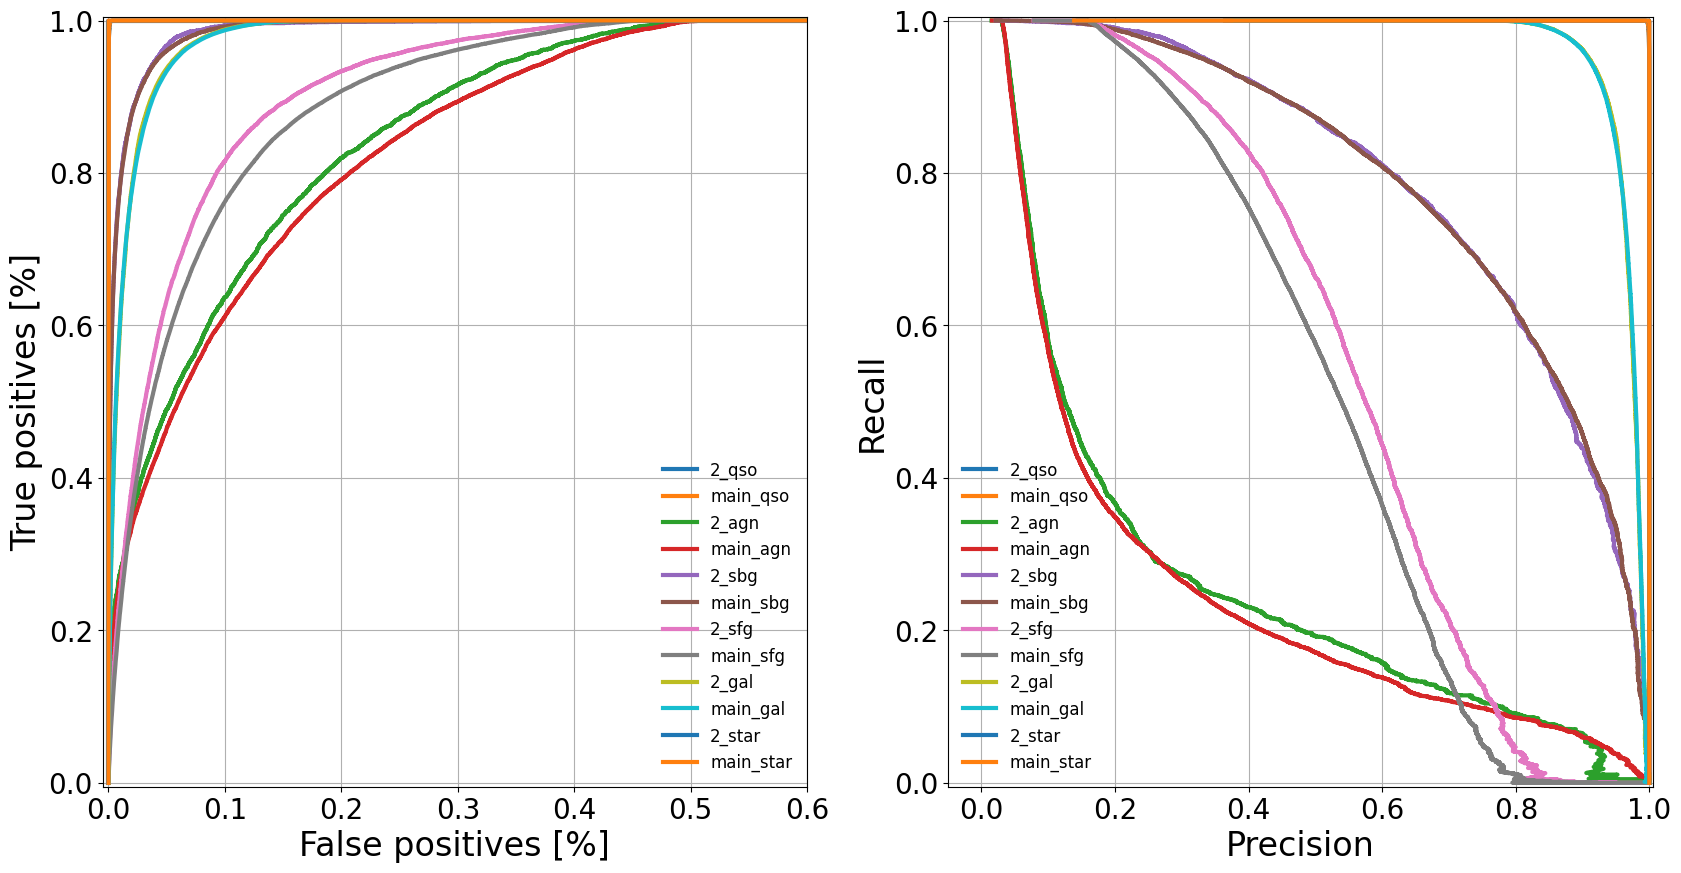

In [104]:
prrc(config_var_color)

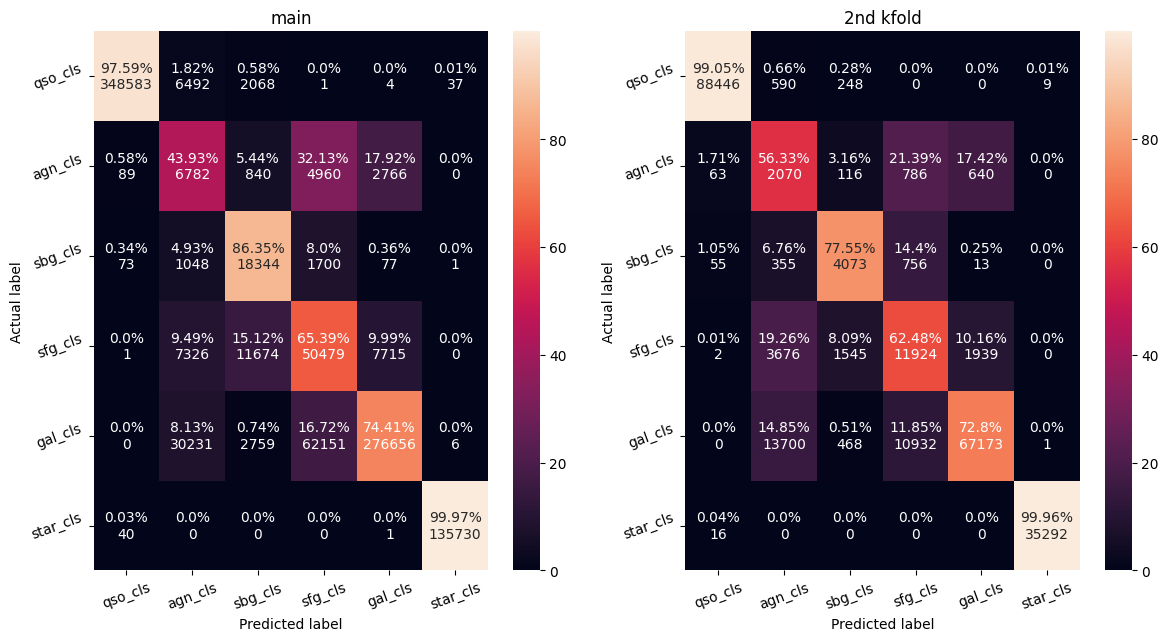

picture Confusion Matrix done


In [10]:
from sklearn.metrics import confusion_matrix
from network import make_custom_index
import seaborn as sns
from matplotlib import pyplot as plt

def picture_confusion_matrix(config):
    
  def plot_cm(ax,data,name):
    
    y = np.argmax(data[config.name_class_cls], axis=1).tolist()
    y_prob = np.argmax(data[config.name_class_prob], axis=1).tolist()

    cm = confusion_matrix(y, y_prob)

    new_cm = np.zeros((len(config.name_class_cls),len(config.name_class_cls)))
    for i in range(len(config.name_class_cls)):
        sum = cm[i,:].sum()
        #print(sum)
        for j in range(len(config.name_class_cls)):
            new_cm[i,j] = round(cm[i,j] / float(sum),5)*100
    new_cm = pd.DataFrame(new_cm, columns=config.name_class_cls, index=config.name_class_cls)
    #print(new_cm)
    annot = new_cm.round(2).astype(str) + "%\n" + cm.astype(str)
    sns.heatmap(new_cm, ax=ax, annot=annot, fmt="")
    ax.set_title(name)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
  
  fig, axs = plt.subplots(1,2)
  fig.set_size_inches(14,7)
  
  name = make_custom_index("2",config.hyperparam["model_variable"]["neuron_count"])
  data = pd.read_csv(f'{config.path_eval}_custom_sm_{name}_prob.csv', header=0, sep=",")
  plot_cm(axs[1],data,"2nd kfold")
  #
  name = make_custom_index("00",config.hyperparam["model_variable"]["neuron_count"])
  data = pd.read_csv(f'{config.path_eval}_custom_sm_{name}_prob.csv', header=0, sep=",")
  plot_cm(axs[0],data,"main")

  #fig.savefig(f'{config.path_pic}/{config.name_sample}_Confusion_matrix.png')
  plt.show(fig)
  plt.close(fig)
  

  print("picture Confusion Matrix done")

picture_confusion_matrix(config_var_color)

In [11]:
from network import make_custom_index
name = make_custom_index('00',config_var_color.hyperparam["model_variable"]["neuron_count"])
data = pd.read_csv(f"{config_var_color.path_eval}_custom_sm_{name}_prob.csv", header=0, sep=",")
data

qso_cls_prob  agn_cls_prob  sbg_cls_prob  sfg_cls_prob  gal_cls_prob   
0           0.000010  3.362411e-01  1.295111e-03  3.719633e-01  2.904907e-01  \
1           0.999995  2.666693e-08  4.846909e-06  2.524803e-12  7.317834e-13   
2           0.000017  1.570376e-01  1.106785e-03  1.259514e-01  7.158870e-01   
3           1.000000  7.464084e-12  7.623353e-10  1.900317e-16  4.437253e-16   
4           0.997673  7.880623e-04  1.538080e-03  3.557908e-07  2.246567e-09   
...              ...           ...           ...           ...           ...   
978629      0.000011  1.543375e-01  6.248688e-04  1.091925e-01  7.358336e-01   
978630      0.000100  2.083326e-01  1.831220e-01  5.410016e-01  6.744356e-02   
978631      0.997472  7.391482e-06  2.519485e-03  2.413421e-08  1.506426e-08   
978632      0.999985  3.534783e-08  1.470133e-05  1.734658e-11  7.367961e-12   
978633      0.000023  3.007654e-01  1.082701e-03  1.189698e-01  5.791593e-01   

        star_cls_prob  qso_cls  agn_cls  sbg_cls  sfg_cls  gal_cls  star_cls  
0        3.089048e-08        0        0        0        0        1         0  
1        5.722033e-12        1        0        0        0        0         0  
2        3.750414e-08        0        0        0        0        1         0  
3        6.943914e-16        1        0        0        0        0         0  
4        7.472501e-12        1        0        0        0        0         0  
...               ...      ...      ...      ...      ...      ...       ...  
978629   9.753752e-09        0        0        0        0        1         0  
978630   1.502958e-07        0        0        0        1        0         0  
978631   1.510510e-06        1        0        0        0        0         0  
978632   9.567830e-11        1        0        0        0        0         0  
978633   4.434576e-08        0        0        0        0        1         0  

[978634 rows x 12 columns]

In [140]:
from data_process import get_features
%matplotlib inline
def Histlog(ax,x,mag,label, bins=50, **kwargs):
    ax.set_xlabel(mag,fontsize=40)
    ax.set_ylabel("count",fontsize=40)
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax.set_yscale('log')
    #ax.set_title(name,fontsize = 50)
    ax.hist(x,bins=bins, label=label,**kwargs)

bins_ = lambda data, binwidth: np.arange(min(data), max(data) + binwidth, step=binwidth)

binwidth = 0.1

def contam_dist_pic(data,config):
    
    print("picture Contamination by mags")

    def contamination_distribution(data,features_name,config):
        bins = config.picture["contam_dist"]["bins"]
        min = data[features_name].min()
        max = data[features_name].max()
        #range_bins = max-min
        mass_mags = np.linspace(min, max, num = bins)
        cls_n = len(config.name_class)
        mass = np.ones((bins,cls_n*cls_n))
        contam_mass = np.zeros((bins,cls_n*cls_n))

        sum_global = np.zeros((bins,cls_n*cls_n))
        
        sum_main = np.zeros(cls_n*cls_n)
        for i in range(bins):
            #min_f = (range_bins*i)/bins + min
            #max_f = (range_bins*(i+1))/bins + min
            if(i+1 == bins):
                break
            min_f = mass_mags[i]
            max_f = mass_mags[i+1]
            #потребує оптимізації, бо O(n^2)
            data_temp = data[(data[features_name] >= min_f) & (data[features_name] < max_f)]
            #print(data_temp)
            #
            y = np.argmax(data_temp[config.name_class_cls], axis=1).tolist()
            y_prob = np.argmax(data_temp[config.name_class_prob], axis=1).tolist()
            #        
            cm = confusion_matrix(y, y_prob)
            if(len(cm)>cls_n-1):
              #print(cm)
              #print(y,y_prob)
              for ii in range(cls_n):
                  sum = 0
                  for jj in range(cls_n):
                      #all correct
                      mass[i][cls_n*ii+jj] += cm[ii][jj]
                      sum += cm[ii][jj]

                      sum_main[cls_n*ii+jj] += cm[ii][jj]
                      sum_global[i][cls_n*ii+jj] = sum_main[cls_n*ii+jj]
                      
                  for jj in range(cls_n):
                      if(sum!=0):
                          contam_mass[i][cls_n*ii+jj] = (cm[ii][jj]/float(sum))*100

        '''            
        fig, axs = plt.subplots(cls_n,cls_n)
        
        for n in range(cls_n*cls_n):
            ii, jj = n//cls_n, n%cls_n
            axs[ii,jj].plot(mass_mags,mass[:,n])
            axs[ii,jj].set_xlabel(features_name)
            axs[ii,jj].set_ylabel('Contamination count')
            axs[ii,jj].set_xlim([min-1,max+1])
        '''
        fig, axs = plt.subplots(2,3)

        fontsize_side = 20
        fontsize_legend = 15

        for n in range(cls_n):

            sum_local = 0
            for ii in range(cls_n):
                sum_local += sum_main[cls_n*n+ii]

            #print("SUM_LOCAL\n\n",sum_local)
            #print(sum_global)
            for ii in range(cls_n):
                if(ii != n):
                    #axs[1,n].plot(mass_mags,contam_mass[:,cls_n*n+ii],label=f"as {config.name_class_prob[ii]}")
                    axs[n//3,n%3].plot(mass_mags,mass[:,cls_n*n+ii],label=f"as {config.name_class_prob[ii]}")
#                    Histlog(axs[n//3,n%3],mass[:,cls_n*n+ii],config.name_class_prob[ii],label=f"as {config.name_class_prob[ii]}",
#                            bins=bins_(mass[:,cls_n*n+ii],binwidth), histtype='step', fill=False, lw=5)
                    
                    
                    #axs[2,n].plot(mass_mags,(sum_global[:,cls_n*n+ii]/sum_local)*100,label=f"as {config.name_class_prob[ii]}")
                else:
                    axs[n//3,n%3].plot(mass_mags,mass[:,cls_n*n+ii],label=f"{config.name_class_cls[n]} true pred")
#                    Histlog(axs[n//3,n%3],mass[:,cls_n*n+ii],config.name_class_prob[ii],label=f"as {config.name_class_prob[ii]}",
#                            bins=bins_(mass[:,cls_n*n+ii],binwidth), histtype='step', fill=False, lw=5)
            
                #print(mass[:,cls_n*n+ii])

            axs[n//3,n%3].set_ylabel('Contamination, % (per bin)', fontsize=fontsize_side)
            #axs[1,n].set_xlabel("mags", fontsize=10)
            #axs[1,n].set_ylabel('Contamination, % (per bin)', fontsize=10)
            #axs[1,0].set_ylabel('Contamination, % (per bin)', fontsize=fontsize_side)

            #axs[0,n].set_xlabel("mags", fontsize=10)
            #axs[0,n].set_ylabel('Contamination count, log10 (per bin)', fontsize=10)
            #axs[0,0].set_ylabel('Contamination count, log10 (per bin)', fontsize=fontsize_side)
            
            axs[n//3,n%3].set_title(config.name_class_cls[n], fontsize=20)

            axs[n//3,n%3].set_xlabel("mags", fontsize=fontsize_side)
            #axs[2,n].set_ylabel('Contamination, %', fontsize=10)
            #axs[2,0].set_ylabel('Contamination, %', fontsize=fontsize_side)

            axs[n//3,n%3].set_xlim([min-1,max+1])
            axs[n//3,n%3].legend(fontsize=fontsize_legend)
            #axs[1,n].set_ylim([,])
        


        #fig.legend()
        fig.supxlabel(features_name, fontsize=30)
        fig.set_size_inches(cls_n*10,30)

        fig.savefig(f'{config.path_pic}/{config.name_sample}_cm_contamination_by_{features_name}.png')
        plt.close(fig)


    name = make_custom_index('00',config.hyperparam["model_variable"]["neuron_count"])
    label = pd.read_csv(f'{config.path_eval}_custom_sm_{name}_prob.csv', header=0, sep=",")
    
    #data = pd.read_csv(f"{config.path_ml_data}/{config.name_main_sample}_all.csv", header=0, sep=',')

    for name in ["W1mproPM"]:
        data_temp = data[name]
        data_temp = pd.concat((data_temp,label),axis=1)
        contamination_distribution(data_temp,name,config)

In [141]:
contam_dist_pic(data,config_var_color)

picture Contamination by mags
[7.8000e+01 9.2000e+01 1.3100e+02 1.5000e+02 1.5800e+02 1.9500e+02
 2.2100e+02 2.6900e+02 2.6000e+02 3.4100e+02 4.2900e+02 4.1300e+02
 4.6100e+02 5.9800e+02 7.0000e+02 7.9200e+02 8.9100e+02 1.0640e+03
 1.1770e+03 1.3470e+03 1.5620e+03 1.6950e+03 1.9990e+03 2.1530e+03
 2.4870e+03 2.8650e+03 3.1500e+03 3.5190e+03 3.9870e+03 4.0960e+03
 4.6620e+03 5.0300e+03 5.3900e+03 5.7280e+03 6.2250e+03 6.6890e+03
 7.3450e+03 7.9550e+03 8.5470e+03 9.1540e+03 1.0364e+04 1.1336e+04
 1.2216e+04 1.2680e+04 1.3429e+04 1.3334e+04 1.3260e+04 1.2819e+04
 1.2086e+04 1.1338e+04 1.0282e+04 9.3030e+03 8.2530e+03 7.2710e+03
 6.6880e+03 6.5090e+03 6.3730e+03 6.4260e+03 6.6730e+03 6.6610e+03
 6.9810e+03 7.0720e+03 7.4220e+03 7.3990e+03 7.5340e+03 7.7940e+03
 7.7680e+03 7.8620e+03 7.8870e+03 7.8430e+03 7.8650e+03 7.6840e+03
 7.5740e+03 7.0550e+03 6.8900e+03 6.4720e+03 5.8150e+03 5.5240e+03
 5.0210e+03 4.4560e+03 3.8760e+03 3.4230e+03 2.7870e+03 2.2330e+03
 1.8250e+03 1.3980e+03 1.0670e+0

In [48]:
from matplotlib import pyplot as plt
%matplotlib inline
def Histlog(ax,x,mag,label, bins=50, **kwargs):
    ax.set_xlabel(mag,fontsize=40)
    ax.set_ylabel(r"$log_{10}(count)$",fontsize=40)
    ax.tick_params(axis='y', which = "major", labelsize=30, length= 10, width = 2)
    ax.tick_params(axis='y', which = "minor", labelsize=30, length= 5, width = 2)
    
    ax.tick_params(axis='x', labelsize=30, length= 5, width = 2)
    ax.set_yscale('log')
    #ax.set_title(name,fontsize = 50)
    ax.hist(x,bins=bins, label=label,**kwargs)

def Hist(ax,x,mag,label, bins=50, **kwargs):
    ax.set_xlabel(mag,fontsize=40)
    ax.set_ylabel("count",fontsize=40)
    ax.tick_params(axis='x', labelsize=30, width = 5)
    ax.tick_params(axis='y', labelsize=30, width = 5)
    #ax.set_title(name,fontsize = 50)
    ax.hist(x,bins=bins, label=label,**kwargs)

bins_ = lambda data, binwidth: np.arange(min(data), max(data) + binwidth, step=binwidth)

In [3]:
data

NameError: name 'data' is not defined

<Figure size 640x480 with 0 Axes>

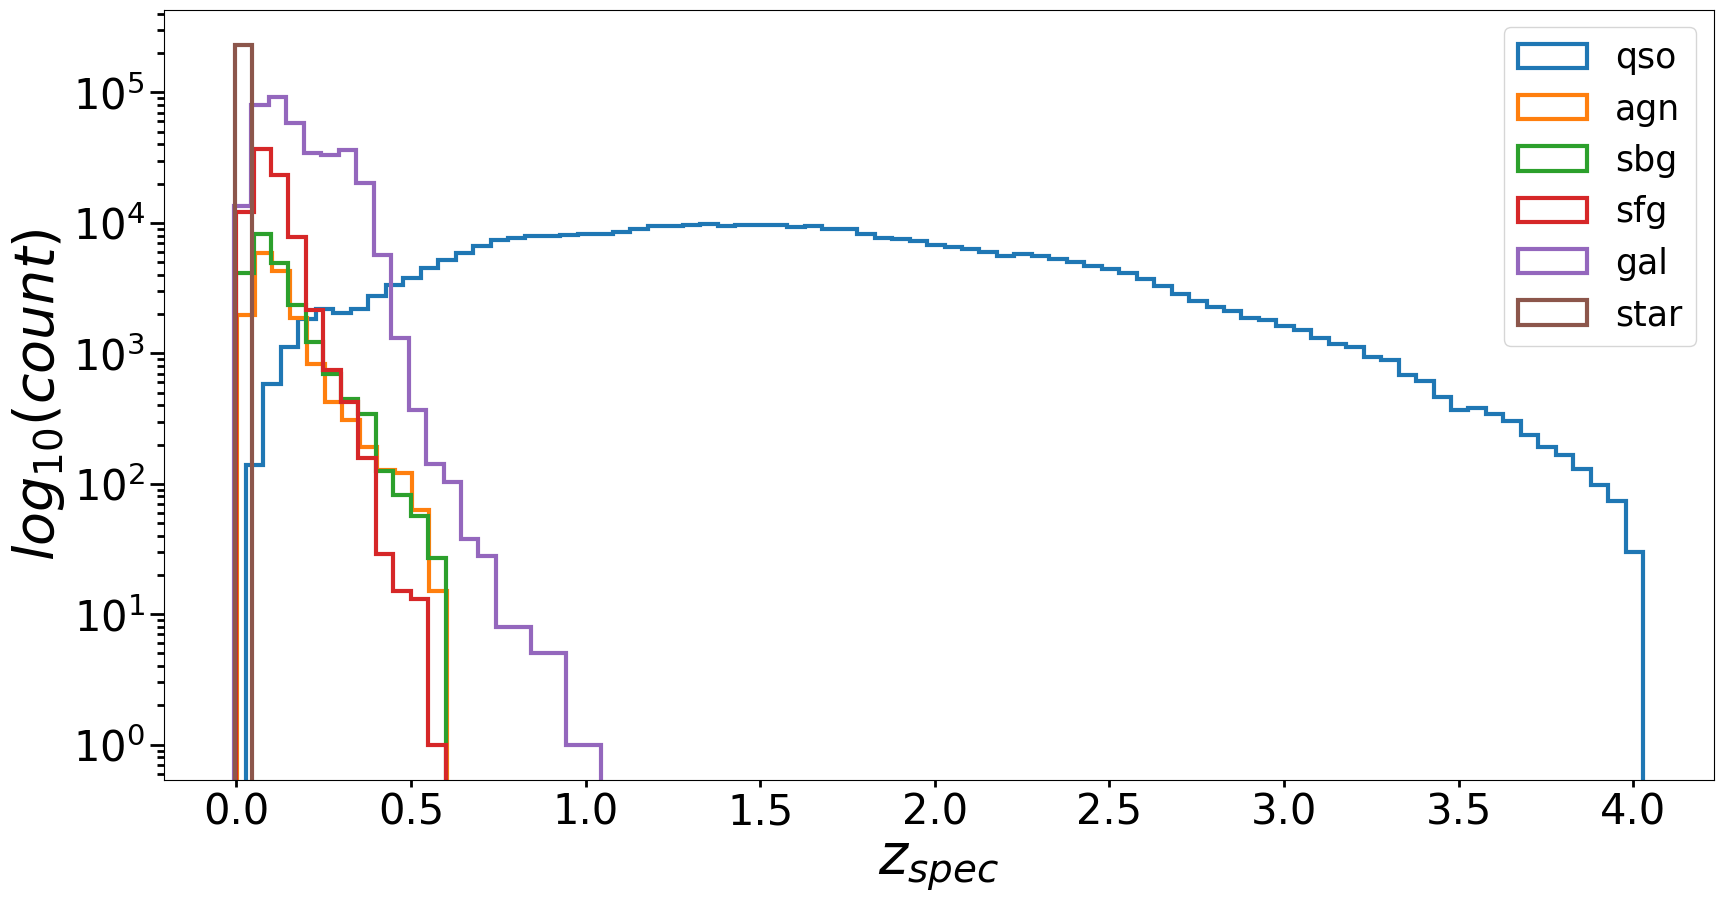

In [51]:
fig=plt.figure()
fig, axs = plt.subplots(1,1)

binwidth = 0.05

fig.suptitle("", fontsize=50)       
for name in config_var_color.name_class:
    data_temp = data[data[f"{name}_cls"] == 1]
    Histlog(axs,data_temp["z"],r"$z_{spec}$", label = name, 
        bins=np.arange(min(data_temp["z"]), max(data_temp["z"]) + binwidth, step=binwidth), 
        histtype='step', fill=config_var_color.picture["hist"]["fill"], lw=3)

    axs.legend(prop={'size': 25})
fig.set_size_inches(20,10)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()

In [43]:
from network import dimention_reduction_tsne
from matplotlib import pyplot as plt
from matplotlib import ticker

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def TSNE_pic(data,label,config):
    
    print("picture by tSNE")
    
    multi_k = 0.05

    x_min,y_min = data.iloc[:,0].min(axis=0)*(1 + multi_k),data.iloc[:,1].min(axis=0)*(1 + multi_k)
    x_max,y_max = data.iloc[:,0].max(axis=0)*(1 + multi_k),data.iloc[:,1].max(axis=0)*(1 + multi_k)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    for n, name in enumerate(config.name_class_cls):
        temp_data = data[label[name] == 1].values
        #print(temp_data)
        ax.scatter(temp_data[:,0],temp_data[:,1], color = colors[n%10], label=config.name_class[n], s=1)
        ax.legend(prop={'size':15}, framealpha=0, markerscale=5)
        ax.tick_params(axis='x', labelsize=20, width = 1)
        ax.xaxis.set_major_formatter(ticker.NullFormatter())
        ax.yaxis.set_major_formatter(ticker.NullFormatter())
        del temp_data
    
    #data.to_csv('',index=False)
    
    ax.set_xlim([x_min,x_max])
    ax.set_ylim([y_min,y_max])
    #del data, label

    #fig.legend()
    fig.set_size_inches(10,10)

    #fig.savefig(f"{config.path_pic}/{config.name_sample}_main_tsne.png")
    plt.show(fig)
    plt.close(fig)
    '''
    for n, name in enumerate(config.name_class_cls):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        temp_data = data[label[name] == 1].values
        #print(temp_data)
        ax.scatter(temp_data[:,0],temp_data[:,1], color = colors[n%10], label=config.name_class[n],s=2)
        ax.legend(prop={'size':10})
        del temp_data

        ax.set_xlim([x_min,x_max])
        ax.set_ylim([y_min,y_max])

        #data.to_csv('',index=False)

        #del data, label

        #fig.legend()
        fig.set_size_inches(10,10)

        fig.savefig(f"{config.path_pic}/{config.name_sample}_{name}_tsne.png")
        plt.close(fig)
    '''
    #del data, label

In [12]:
from data_process import get_features
data_tsne = dimention_reduction_tsne(data[get_features(config_var_color.features["train"],config_var_color)].values,config_var_color)

['var', 'color']
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 96336 samples in 0.138s...
[t-SNE] Computed neighbors for 96336 samples in 7.881s...
[t-SNE] Computed conditional probabilities for sample 1000 / 96336
[t-SNE] Computed conditional probabilities for sample 2000 / 96336
[t-SNE] Computed conditional probabilities for sample 3000 / 96336
[t-SNE] Computed conditional probabilities for sample 4000 / 96336
[t-SNE] Computed conditional probabilities for sample 5000 / 96336
[t-SNE] Computed conditional probabilities for sample 6000 / 96336
[t-SNE] Computed conditional probabilities for sample 7000 / 96336
[t-SNE] Computed conditional probabilities for sample 8000 / 96336
[t-SNE] Computed conditional probabilities for sample 9000 / 96336
[t-SNE] Computed conditional probabilities for sample 10000 / 96336
[t-SNE] Computed conditional probabilities for sample 11000 / 96336
[t-SNE] Computed conditional probabilities for sample 12000 / 96336
[t-SNE] Computed conditional pro

In [39]:
data_tsne = pd.DataFrame(data_tsne)
label = data[config_var_color.name_class_cls]

picture by tSNE


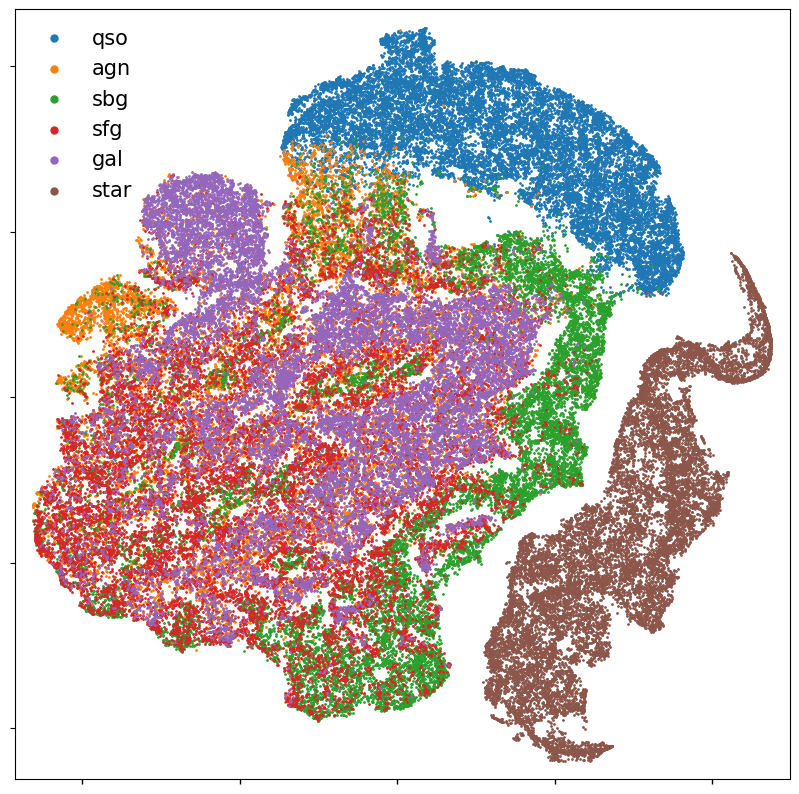

In [44]:
TSNE_pic(data_tsne,label,config_var_color)